In [1]:
import numpy as np
import qutip as qt
import scipy as sp
import scipy.linalg as spla
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pickle
from tqdm import tqdm
import os
import plotsmodule
from plotsmodule import *
from joblib import Parallel, delayed
import json
import sBs
import bits
import metrology
import importlib
import backaction
importlib.reload(plotsmodule)
importlib.reload(sBs)
importlib.reload(bits)
importlib.reload(metrology)
importlib.reload(backaction)
from sBs import *
from bits import *
from metrology import *
from backaction import *

In [2]:
path = os.getcwd()
path_sBs = path + '/sBs-noiseless/'
path_sbs_noise = path + '/sbs-noise/'
path_sbs_noise_figures = path_sbs_noise + "/Figures/"
path_sBs_MP = path_sBs + '/metrological potential/'
path_sBs_MP_FI = path_sBs_MP + '/FI/'
path_sBs_MP_filter = path_sBs_MP_FI + '/filter/'
path_sBs_MP_ML = path_sBs_MP + '/maximum likelihood/'
path_sBs_MP_BA = path_sBs_MP + '/backaction/'
path_sBs_MP_BA_test = path_sBs_MP_BA + '/test/'
path_figures = path_sBs + '/figures/'
path_figures_data = path_sBs + '/figures/data/'
path_data_sBs = path_sBs+'/sBs/'
path_data_sBs_sensor = path_sBs+'/sBs/sensor/'
path_data_sBs_probabilities = path_sBs+'/sBs/probabilities/'
path_sBs_bayesian = path_sBs+"/data/bayesian/"
path_posters = path+"/posters/"
os.makedirs(path_sBs_MP, exist_ok=True)
os.makedirs(path_sBs_MP_FI, exist_ok=True)
os.makedirs(path_sBs_MP_filter, exist_ok=True)
os.makedirs(path_sBs_MP_ML, exist_ok=True)
os.makedirs(path_sBs_MP_BA, exist_ok=True)
os.makedirs(path_sBs_MP_BA_test, exist_ok=True)
os.makedirs(path_sBs_bayesian, exist_ok=True)

# Running backaction evading in parallel

In [ ]:
def running_BAEM_parallel(Delta,sigma,sensor,repeat_baem,T, M, estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,runs):
    
    def single_run():
        squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0, bitstrings  = backaction_evading_sBs_run_notrhos(Delta,sigma,sensor,repeat_baem, T, M ,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits)
        return np.array([squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s, bitstrings])

    result = Parallel(n_jobs=20)(delayed(single_run)() for _ in tqdm(range(runs)))
    return np.array(result)#shape [run][0=SEq,1=SEp,2=estq,3=estp][repeats]


Delta, R0 = .3, 120
R1, k, steps, l = 15, 0, 51, np.sqrt(2*np.pi)
gauges = [0,0]
T_range = [1,2,4,8]
T = 8
M = 1
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_sBs_sensor+name)
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = stddev_range[np.argmin(np.abs(stddev_range-0.15*l))]
index_sigma = np.argmin(np.abs(stddev_range-sigma))
print('sigma:',sigma/l)

steps2 = 101
qrange = (l)*np.linspace(-1.0,1.0,steps2)
print(Delta, T, k , steps2)

name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
with open(path_sBs_bayesian+name+'.pkl', 'rb') as file:
    dictionary = pickle.load(file)
estimators_all = dictionary['estimators_all']
estimators_allqbits_p0 = estimators_all[index_sigma]
estimators_allpbits_q0 = estimators_all[index_sigma]

# runs_range = [100,200,500,1000,2000,4000,8000], T_range = [1,2,4,8], M =1, Delta = 0.3, sigma = 0.15*l, sample = 0
runs_range = [100,200,500,1000,2000,4000,8000]
for i in range(1):
    for runs in runs_range:
        for T in T_range:
            name = 'expectation_value_q_allqbits_Bayesian_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps2)
            exp_qrange_allqbits = np.load(path_sBs_bayesian+name+'.npy')
            repeat_baem = 1
            result = running_BAEM_parallel(Delta,sigma,sensor,repeat_baem, T,M, estimators_allqbits_p0, estimators_allpbits_q0, gauges, exp_qrange_allqbits, runs)
            result = np.array(result)

            name = 'backaction_evading_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}_sample={6:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem,i)
            np.save(path_sBs_MP_BA_test+name,result)

sigma: 0.15159806655254446
0.3 8 0 101






/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/Projects/GKP-metrology/LL_env_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning

NameError: name 'p0s' is not defined

# Variance of the mean-square error

In [ ]:
k, steps, R = 0,51,10
Delta_range = [0.3]
T_range = [1,2,4,8]


for Delta in Delta_range:

    cd = np.cosh(Delta**2)
    q0_range = (l)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_sBs_probabilities+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]
    stddev_range = np.arange(0.05,l/4+.1,.01)
    for T in T_range:
        MSEs = []
        mse_qrange = []
        posteriors_all = []
        estimators_all = []
        for stddev in tqdm(stddev_range):
            mse_q, MSE, posteriors, estimators, probs_b = gaussian_MSE_qmap(stddev,probs_qp0_allbits,R,T,q0_range,steps)
            MSEs.append(MSE)
            mse_qrange.append(mse_q)
            posteriors_all.append(posteriors)
            estimators_all.append(estimators)
        MSEs = np.array(MSEs)
        mse_qrange = np.array(mse_qrange)
        posteriors_all = np.array(posteriors_all)
        estimators_all = np.array(estimators_all)
        dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators_all':estimators_all}
        name = 'MSEsquared_gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        with open(path_sBs_bayesian+name+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)
# T = 4
# stddev = l/4
# mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
# print(MSE/stddev**2)
# print('posterior',np.sum(posteriors[2]))
# fig, axs = plt.subplots(1,3,figsize=(12,4))
# ax1, ax2, ax3 = axs
# ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
# ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
# ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

100%|██████████| 68/68 [11:35<00:00, 10.23s/it]


### plot

0.5 0.5
variance [1.500000e-05 2.500000e-05 4.000000e-05 6.400000e-05 9.600000e-05
 1.370000e-04 1.870000e-04 2.450000e-04 3.120000e-04 3.870000e-04
 4.690000e-04 5.570000e-04 6.510000e-04 7.510000e-04 8.560000e-04
 9.680000e-04 1.086000e-03 1.215000e-03 1.359000e-03 1.524000e-03
 1.720000e-03 1.958000e-03 2.257000e-03 2.638000e-03 3.130000e-03
 3.769000e-03 4.598000e-03 5.671000e-03 7.051000e-03 8.812000e-03
 1.103800e-02 1.382600e-02 1.728000e-02 2.151400e-02 2.664900e-02
 3.281100e-02 4.012900e-02 4.873000e-02 5.873800e-02 7.027100e-02
 8.343500e-02 9.832600e-02 1.150230e-01 1.335900e-01 1.540700e-01
 1.764870e-01 2.008450e-01 2.271260e-01 2.552920e-01 2.852870e-01
 3.170360e-01 3.504450e-01 3.854100e-01 4.218090e-01 4.595130e-01
 4.983830e-01 5.382730e-01 5.790330e-01 6.205110e-01 6.625540e-01
 7.050110e-01 7.477320e-01 7.905720e-01 8.333930e-01 8.760600e-01
 9.184470e-01 9.604350e-01 1.001915e+00]
min ratio 0.34305776028088303
max 2.2355850997779227 19.41804545317365 variance 0.00

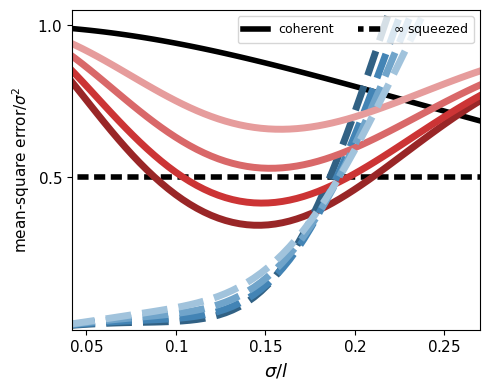

In [46]:
def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

Delta, k, steps, R = 0.3,0,51,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.arange(0.05,l/4+.1,.01)

print(coherent_limit(1),gaussian_limit(1))

fig, ax = plt.subplots(1,1,figsize=(5,4))

line1, = ax.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
path_sBs_bayesian = path_sBs+"data/bayesian/" 
lines = [line1,line2]

T_range = [8,4,2,1]
for i in range(4):
    T = T_range[i]
    name2 = 'MSEsquared_gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_sBs_bayesian+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    with open(path_sBs_bayesian+name2+'.pkl', 'rb') as f:
        dictionary2 = pickle.load(f)
    MSE = dictionary['MSEs']
    MSE2 = dictionary2['MSEs']
    # print('MSE^2',MSE**2)
    # print('MSE2',MSE2)
    print('variance',np.round(MSE2-MSE**2,6))
    variance_MSE = MSE2-MSE**2


    MSE_q = dictionary['mse_qrange']

    with open(path_sBs_bayesian+name2+'.pkl', 'rb') as f:
        dictionary2 = pickle.load(f)
    MSE2 = dictionary2['MSEs']
    MSE_p = dictionary2['mse_qrange']

    shine = .4+.3*np.log(T)
    if i==2:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5,label='Bayesian')
        line4, = ax.plot(stddev_range,variance_MSE/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--',label='Bayesian')
        # ax.plot(stddev_range,MSE2/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--')
    else:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5)
        line4, = ax.plot(stddev_range,variance_MSE/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--',label='Bayesian')

        # ax.plot(stddev_range,MSE2/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--')

    print('min ratio',np.min(MSE/stddev_range**2))

    variance_list = stddev_range**2
    r_array = minimum_r(variance_list,MSE)
    r_max, argmax = np.max(r_array), np.argmax(r_array)
    print('max',r_max, 10*np.log10(np.exp(2*r_max)), 'variance',variance_list[argmax])


handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(0,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

plt.tight_layout()
# name = 'noiseless-gaussian-delta={0:.2f}'.format(Delta)
# plt.savefig(path_figures+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
# plt.show()

4